# DATA ENCODER

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler
%config IPCompleter.greedy=True

## UPLOAD DATA

In [120]:
path = '../../'

In [121]:
name_cat = 'cat_result_eda.pickle'
name_num = 'num_result_eda.pickle'

In [122]:
cat = pd.read_pickle(path + '/02_Data/03_Work/' + name_cat)
num = pd.read_pickle(path + '/02_Data/03_Work/' + name_num)

We remember what we had identified in previous phases and we organized it by type of action.

Modify with pandas/numpy:

* Create the target from state
* Discretize num_months_since_last_delay
* In housing, combine NONE and OTHER
* In order to combine renewable_energy, educational and vacation in 'others'

Modify with scikit learn:

* The description variable could be worked with a TF-IDF Vectorizer
* Convert num_derogatory to binary

## VARIABLES CREATION AND TRANSFORMATION

### Target  for model PD

In [123]:
cat.estado.value_counts()

Fully Paid                                             66291
Current                                                54084
Charged Off                                            16383
Late (31-120 days)                                      1357
In Grace Period                                          532
Late (16-30 days)                                        278
Does not meet the credit policy. Status:Fully Paid       125
Does not meet the credit policy. Status:Charged Off       55
Default                                                    3
Name: estado, dtype: int64

In [124]:
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,anknown,debt_consolidation,36 months,Current,0
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,anknown,debt_consolidation,36 months,Charged Off,1
87998444,executive director,9 years,Source Verified,B,MORTGAGE,anknown,credit_card,60 months,Current,0
103448519,Web site administrator,10+ years,Not Verified,A,MORTGAGE,anknown,credit_card,36 months,Current,0
61349005,test operator,10+ years,Source Verified,C,MORTGAGE,anknown,credit_card,60 months,Charged Off,1
...,...,...,...,...,...,...,...,...,...,...
129396054,Field Manager,10+ years,Source Verified,D,OWN,anknown,debt_consolidation,60 months,Current,0
119242742,anknown,anknown,Source Verified,C,RENT,anknown,debt_consolidation,36 months,Late (31-120 days),0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,anknown,other,36 months,Current,0


In [125]:
cat.drop(columns='estado',inplace=True)

### Target for model EAD

It will be the percentage of the principal that had not been amortized.

Therefore: pending / main

First we have to build the outstanding as the principal minus the amortized.

In [126]:
num['rest'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,rest
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08
61349005,60000.0,20.22,1.0,10.0,75.0,68.0,0.0,0.0,33.0,22800.0,13.99,530.40,19036.21,1193.00,3763.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49


In [127]:
num['target_ead'] = num.rest / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,rest,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154
61349005,60000.0,20.22,1.0,10.0,75.0,68.0,0.0,0.0,33.0,22800.0,13.99,530.40,19036.21,1193.00,3763.79,0.165079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149


### Target for model LGD

It will be the percentage of the pending that is NOT recovered in case of non-payment.

Therefore: 1 - (imp_recovered / rest)

In [128]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.rest)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,rest,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154,1.000000
61349005,60000.0,20.22,1.0,10.0,75.0,68.0,0.0,0.0,33.0,22800.0,13.99,530.40,19036.21,1193.00,3763.79,0.165079,0.683032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Nulls occur when the slope is zero. Therefore we can impute them by zeros.

In [129]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,rest,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,3637.04,0.363704,1.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,14557.00,0.539148,1.000000
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154,1.000000
61349005,60000.0,20.22,1.0,10.0,75.0,68.0,0.0,0.0,33.0,22800.0,13.99,530.40,19036.21,1193.00,3763.79,0.165079,0.683032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,1503.94,0.601576,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


targets created.

In [130]:
cat['target_pd'].mean()

0.11818874543520143

In [131]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139108.0,0.337689,0.369413,-0.000032,0.0,0.128760,0.726015,1.0
target_lgd,139108.0,0.508278,0.490372,-0.275957,0.0,0.849967,1.000000,1.0


We limit to ensure that they are always between 0 and 1

In [132]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [133]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139108.0,0.337689,0.369413,0.0,0.0,0.128760,0.726015,1.0
target_lgd,139108.0,0.508307,0.490338,0.0,0.0,0.849967,1.000000,1.0


### Remaining variables

num_meses_desde_ult_retraso

Let's start by reviewing the relationship with the target_pd

In [134]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [135]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']

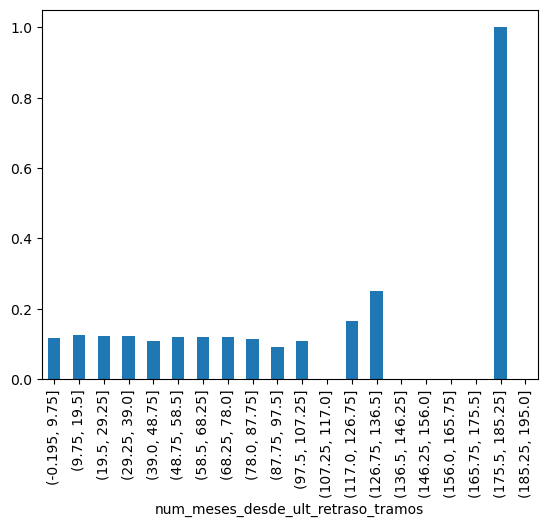

In [136]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

The distribution of the target in this variable does not give us confidence, so we discard it.

In [137]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

in vivienda merge ANY, NONE y OTHER

In [138]:
cat.vivienda.value_counts()

MORTGAGE    68246
RENT        55275
OWN         15515
ANY            57
OTHER          12
NONE            3
Name: vivienda, dtype: int64

In [139]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [140]:
cat.vivienda.value_counts()

MORTGAGE    68318
RENT        55275
OWN         15515
Name: vivienda, dtype: int64

In order to join renewable_energy, educational and wedding in 'other'

In [141]:
cat.finalidad.value_counts()

debt_consolidation    79071
credit_card           31509
home_improvement       9030
other                  8580
major_purchase         3139
medical                1665
small_business         1565
car                    1419
moving                  990
vacation                953
house                   933
wedding                 141
renewable_energy         92
educational              21
Name: finalidad, dtype: int64

In [142]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'OTHER')

In [143]:
cat.finalidad.value_counts()

debt_consolidation    79071
credit_card           31509
home_improvement       9030
other                  8580
major_purchase         3139
medical                1665
small_business         1565
car                    1419
moving                  990
vacation                953
house                   933
OTHER                   254
Name: finalidad, dtype: int64

## CATEGORICAL TRASFORMATION

### One Hot Encoding

#### Variables to apply OHE

In [144]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

In [145]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### FIT

In [146]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

C:\Users\luise\anaconda3\envs\riesgos\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Save as Dataframe

In [147]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables to apply

In [148]:
var_oe = ['antigüedad_empleo','rating']

#### Order de of variables

In [149]:
#Order
order_seniority_employment = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Order of second variable
order_rating = ['A','B','C','D','E','F','G']

#### Instanciar

In [150]:
oe = OrdinalEncoder(categories = [order_seniority_employment,order_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Fit and apply

In [151]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Save as dataframe

In [152]:
#Add suffix
nombres_oe = [variable + '_oe' for variable in var_oe]

cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

### Dates and texts

Upload stopwords and clean

In [153]:
stop = pd.read_csv(path + '/01_Documents/stop_words_english.txt',names = ['termino'])

def remove_tildes(word):
    #Define version with and without tilde.
    with_ = 'áéíóúüñÁÉÍÓÚÜÑ'
    without = 'aeiouunAEIOUUN'
    traductor = str.maketrans(with_,without)
    return(word.translate(traductor))

stop['cleans'] = stop.termino.transform(remove_tildes)

Apply tf-idf.

In [154]:
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.cleans.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

#Fit
descripcion = tfidf.fit_transform(cat.descripcion)

C:\Users\luise\anaconda3\envs\riesgos\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [155]:
tfidf.vocabulary_

{'borrower': 15,
 '07': 6,
 '13': 12,
 'consolidate': 29,
 'credit': 31,
 'card': 26,
 'years': 49,
 'br': 22,
 'borrower 07': 20,
 'credit card': 32,
 'bills': 14,
 'pay': 42,
 'payments': 46,
 'cards': 28,
 'monthly': 41,
 'paying': 44,
 'debt': 35,
 'rate': 47,
 'credit cards': 34,
 '12': 11,
 'borrower 12': 21,
 'loan': 38,
 '11': 10,
 '09': 8,
 'job': 37,
 'time': 48,
 '10': 9,
 'br br': 24,
 'high': 36,
 'payment': 45,
 'pay credit': 43,
 '06': 5,
 'borrower 06': 19,
 'money': 39,
 '04': 3,
 '02': 1,
 '05': 4,
 'month': 40,
 'borrower 02': 17,
 '14': 13,
 'consolidation': 30,
 '08': 7,
 '03': 2,
 'borrower 03': 18,
 'br borrower': 23,
 'br br borrower': 25,
 'card debt': 27,
 'credit card debt': 33,
 '01': 0,
 'borrower 01': 16}

It does not seem that these terms can generate additional information to what we have, so we will not include this variable in the models.

### NUMERICAL TRANSFORMATION

### Binarize variables

#### To binarize

In [156]:
var_bin = ['num_derogatorios']

In [157]:
bin = Binarizer(threshold=0)

#### Fit and apply

In [158]:
num_bin = bin.fit_transform(num[var_bin])

#### Save as dataframe

In [159]:
#Add suffix
names_bin = [variable + '_bin' for variable in var_bin]

num_bin = pd.DataFrame(num_bin,columns = names_bin)

In [160]:
names_bin

['num_derogatorios_bin']

## VARIABLES RE-SCALE 

###  Min-Max

Join  datasets to RE-SCALE.

In [161]:
num_escale = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [162]:
df_res = pd.concat([cat_oe,num_escale], axis=1)

#### Variables to re-escale with Min-Max

In [163]:
var_mms = df_res.columns

In [164]:
mms = MinMaxScaler()

#### Fit and Apply

In [165]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Save as dataframe

In [166]:
#Add Suffix
names_mms = [variable + '_mms' for variable in var_mms]

df_mms = pd.DataFrame(df_mms,columns = names_mms)

## JOIN DATASETS

### Create a list with the dataframes and variables to include in the analytical table for the PD model

In [167]:
include_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Join all the dataframes in the analytics dashboard for the PD model

In [169]:
df_pd = pd.concat(include_pd, axis = 1)

In [170]:
df_pd.set_index('id_cliente',inplace=True)

### Create a list with the dataframes and variables to include in the analytical table for the EAD model

In [171]:
include_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Join all dataframes in the analytics dashboard for the EAD model


In [172]:
df_ead = pd.concat(include_ead, axis = 1)

In [173]:
df_ead.set_index('id_cliente',inplace=True)

### list with the dataframes and variables to be included in the analytical table for the LGD model

In [174]:
include_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Join all the dataframes in the analytical dashboard for the LGD model

In [175]:
df_lgd = pd.concat(include_lgd, axis = 1)

In [176]:
df_lgd.set_index('id_cliente',inplace=True)

## SAVE DATASETS AFTER  DATA tRANSFORMATION

In [177]:
path_df_tablon_pd = path + '/02_Data/03_Work/' + 'df_tablon_pd.pickle'
path_df_tablon_ead = path + '/02_Data/03_Work/' + 'df_tablon_ead.pickle'
path_df_tablon_lgd = path + '/02_Data/03_Work/' + 'df_tablon_lgd.pickle'

In [178]:
df_pd.to_pickle(path_df_tablon_pd)
df_ead.to_pickle(path_df_tablon_ead)
df_lgd.to_pickle(path_df_tablon_lgd)